<div style="border:solid green 3px; padding: 20px">
<b>Результат участия в Kaggle Competition:</b>  
    
    Accuracy: 0.99239
    Место в турнирной таблице: 237 из 1679 (14.1%)

# MNIST: Digit Recognizer

**Задача:** Cоздать многоклассовый классификатор, который на основе feature vector $\textbf{x}^{(i)}$ определяет значение соовтетсвующей ему цифры от 0 до 9. Данная задача — задача классификации; для обучения модели используется обучение с учителем.

**Данные**: Файлы `mnist_train.csv` и `mnist_test.csv` соедржат обучающиую и тестовую выборки соовтетственно; формат предсказания — датафрейм из двух столбцов: `ImageId` и `Label`.

**Метрика**: Accuracy — доля правильно идентифицированных наблюдений.

## 1. Получение данных

In [36]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from scipy import stats
from scipy.ndimage import shift

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
plt.style.use('https://drive.google.com/uc?id=1NKA45YUOjoDwewGrI88Nx_hrqtBv5kuI&export=download')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

Получим обучающую и тестовую выборки и сохраним их в переменные `X_train` и `X_test` сооветственно. Значения целевой переменной — `Label` — сохраним в переменную `y`:

In [6]:
X_train = pd.read_csv('https://drive.google.com/uc?id=1UZVdXY1tKgQKYfMc4r9WbjOw4kOxvtaf&export=download')
X_test = pd.read_csv('https://drive.google.com/uc?id=1kruOSAm1rz_RX_OjaLDekwysNqhQsAKE&export=download')
submission = pd.read_csv('https://drive.google.com/uc?id=1Ho3H1Fn6XyWuKCzPNE-Zj-TDcfMqPT0x&export=download')

y = X_train['label']
X_train = X_train.drop('label', axis=1)

## 2. Исследовательский анализ данных

Данный датасет уже является подготовленным и не содержит пропусков. Познакомимся с данными:

In [7]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,...,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Размерность данных:

In [8]:
print(f'X_train: {X_train.shape}\ny:       {y.shape}\nX_test:  {X_test.shape}')

X_train: (42000, 784)
y:       (42000,)
X_test:  (28000, 784)


Сколько обучающих примеров для различных цифр представлено:

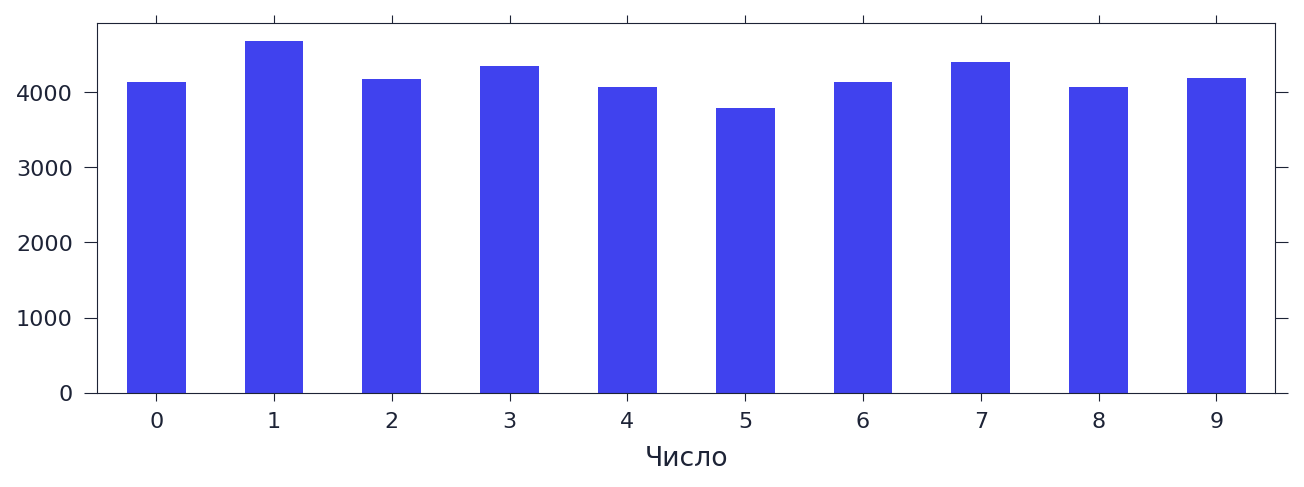

In [9]:
ax = subplots(figsize=(9.5, 3))[1]
ax = y.value_counts().sort_index().plot.bar()
ax.set_xticklabels(np.arange(0, 10, 1), rotation=0)
ax.set_xlabel('Число');

Что из себя представляют строки `X_train`:

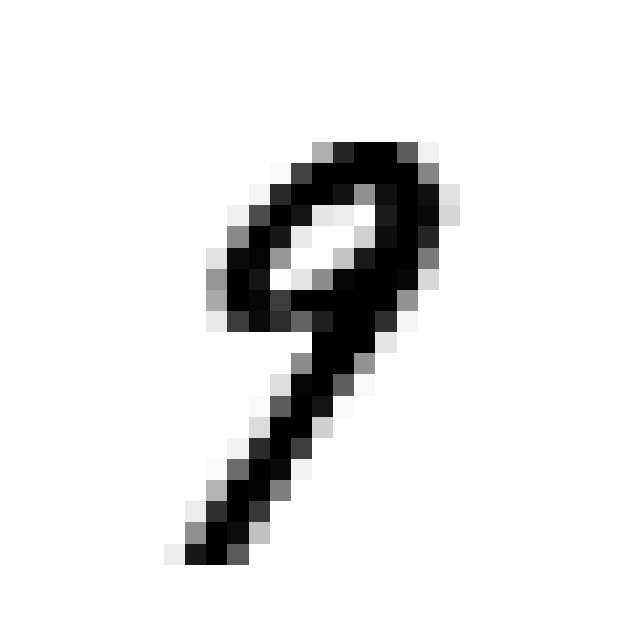

In [10]:
digit = X_train.iloc[27]
digit_array = np.array(digit).reshape(28, 28)

plt.imshow(digit_array, cmap='binary')
plt.axis('off')
plt.show()

## 3. Предобработка данных

Увеличим размерность `X_test`: создадим функцию, которая для каждого примера из обучающей выборки создает 4 дополнительных — сдвинутых на несколько пикселей в каждую сторону:

In [12]:
def shift_digit(digit_array, dx, dy):
    '''
    Функция принимает массив-список значений пикселей и возвращает
    новый массив, сдвинутый на значения dx и dy
    '''
    return shift(digit_array.reshape(28, 28), [dy, dx]).reshape(784)

Проверим работу функции:

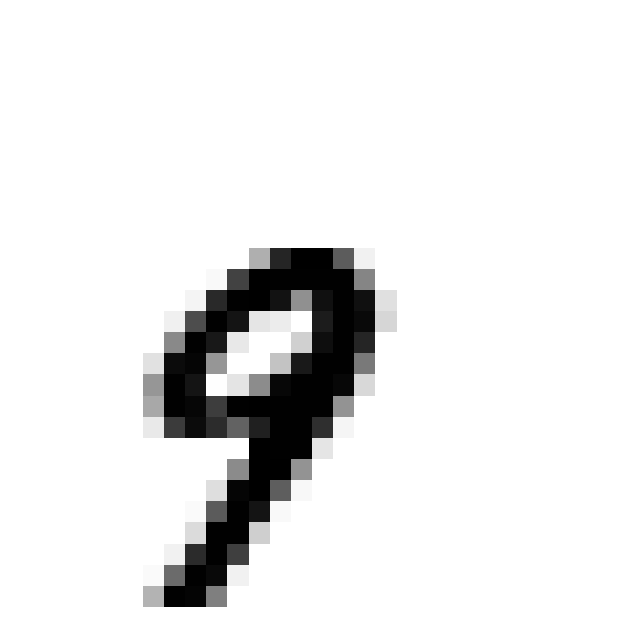

In [13]:
plt.imshow(shift_digit(np.array(digit), -3, 5).reshape(28, 28), cmap='binary')
plt.axis('off')
plt.show()

Создадим расширенный датафрейм `X_exp` с результатами применения функции `get_shift`:

In [14]:
X_exp = [X_train]
y_exp = [y]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):

    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train,
                                         dx=dx, dy=dy)
    X_exp.append(shifted_images)
    y_exp.append(y)

X_exp = np.concatenate(X_exp)
y_exp = np.concatenate(y_exp)

# Проверим размерности
print(f'X_exp: {X_exp.shape}\ny_exp: {y_exp.shape}')

X_exp: (210000, 784)
y_exp: (210000,)


Обработаем значения `X_train`, `X_test` и `X_exp` с помощью `MinMaxScaler`:

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_exp = scaler.fit_transform(X_exp)

Изменим размерность обучающих и тестовых примеров:

In [20]:
X_exp = X_exp.reshape((X_exp.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

# Проверим размерности
print(f'X_exp: {X_exp.shape}\nX_test: {X_test.shape}')

X_exp: (210000, 28, 28, 1)
X_test: (28000, 28, 28, 1)


Преобразуем `y_exp` с помощью One-Hot-Encoding:

In [23]:
y_exp = to_categorical(y_exp, num_classes=10)
y_exp

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Разделим `X_exp`, `y_exp` на выборки для обучения и валидации:

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_exp, y_exp, test_size = 0.1)

## 4. Создаем нейронную сеть

Создаем модель:

In [42]:
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', padding='same', input_shape = (28, 28, 1)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(16, kernel_size=(5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 batch_normalization_12 (Ba  (None, 28, 28, 6)         24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 6)         0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 6)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 16)        2416      
                                                                 
 batch_normalization_13 (Ba  (None, 14, 14, 16)       

Compile и Fit:

In [44]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
history = model.fit(X_train, y_train, batch_size=86, epochs=30,
                    validation_data=(X_val, y_val), verbose=2)

Epoch 1/30
2198/2198 - 155s - loss: 0.1287 - accuracy: 0.9593 - val_loss: 0.0410 - val_accuracy: 0.9875 - 155s/epoch - 71ms/step
Epoch 2/30
2198/2198 - 150s - loss: 0.0511 - accuracy: 0.9837 - val_loss: 0.0286 - val_accuracy: 0.9916 - 150s/epoch - 68ms/step
Epoch 3/30
2198/2198 - 151s - loss: 0.0394 - accuracy: 0.9875 - val_loss: 0.0215 - val_accuracy: 0.9932 - 151s/epoch - 69ms/step
Epoch 4/30
2198/2198 - 151s - loss: 0.0331 - accuracy: 0.9892 - val_loss: 0.0178 - val_accuracy: 0.9940 - 151s/epoch - 69ms/step
Epoch 5/30
2198/2198 - 150s - loss: 0.0281 - accuracy: 0.9909 - val_loss: 0.0234 - val_accuracy: 0.9926 - 150s/epoch - 68ms/step
Epoch 6/30
2198/2198 - 154s - loss: 0.0242 - accuracy: 0.9922 - val_loss: 0.0160 - val_accuracy: 0.9949 - 154s/epoch - 70ms/step
Epoch 7/30
2198/2198 - 150s - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.0149 - val_accuracy: 0.9953 - 150s/epoch - 68ms/step
Epoch 8/30
2198/2198 - 159s - loss: 0.0202 - accuracy: 0.9932 - val_loss: 0.0123 - val_accuracy: 

Визуализируем результаты обучения:

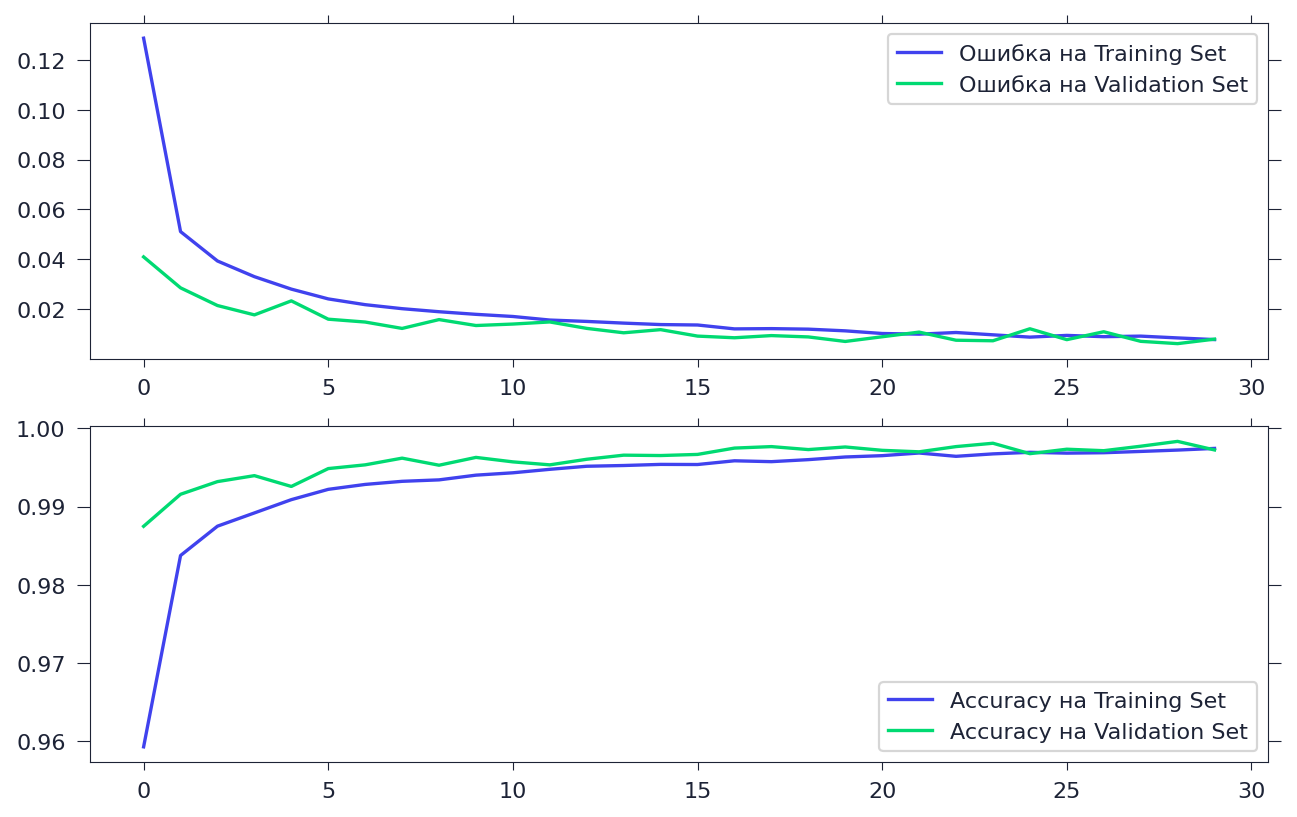

In [46]:
fig, axes = subplots(figsize=(9.5, 6), nrows=2)

axes[0].plot(history.history['loss'], label='Ошибка на Training Set')
axes[0].plot(history.history['val_loss'], label='Ошибка на Validation Set')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Accuracy на Training Set')
axes[1].plot(history.history['val_accuracy'], label='Accuracy на Validation Set')
axes[1].legend();

Проведем анализ ошибок — для этого построим Confusion Matrix:

657/657 [==============================] - 7s 10ms/step


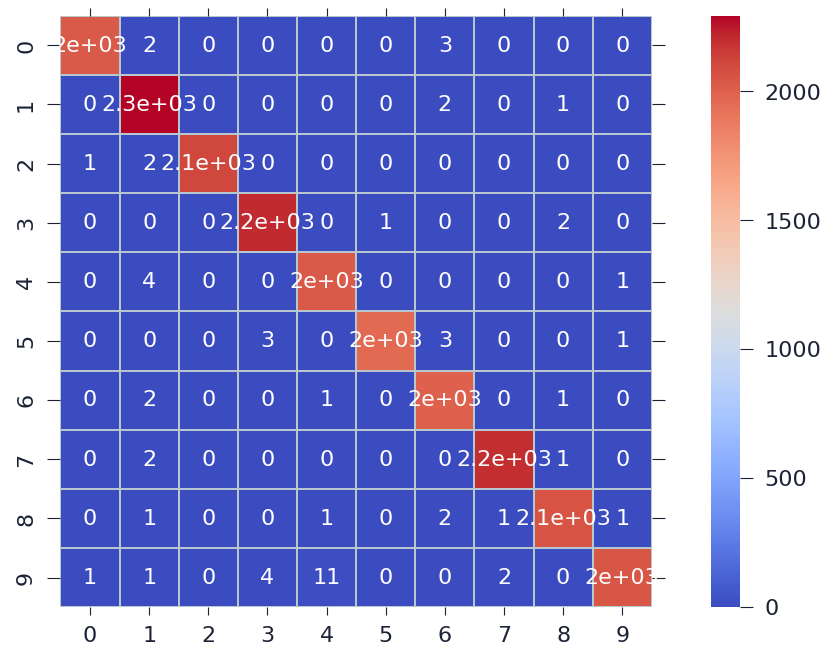

In [49]:
# Предсказания
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Визуализация
ax = subplots(figsize=(9.5, 4.8))[1]
sns.heatmap(conf_matrix, annot=True, ax=ax, cmap='coolwarm', square=True,
            linewidths=0.002, linecolor='#B8C6CE');

Подготовим файл для участия в соревновании Kaggle:

In [53]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis = 1)

submission = pd.read_csv('https://drive.google.com/uc?id=1Ho3H1Fn6XyWuKCzPNE-Zj-TDcfMqPT0x&export=download')
submission['Label'] = preds
submission.to_csv('submission.csv', index=False)

875/875 [==============================] - 9s 11ms/step


Результат участия: Accuracy = 0.99239.

<img src="mnist.png" alt="ext"/>